In [77]:
%matplotlib inline

from __future__ import absolute_import, division, print_function
import nltk
import numpy as np
from gensim.models import word2vec
import re
import multiprocessing
import sklearn.manifold
import pandas as pd
import seaborn as sns
import os
import pprint
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, normalize


In [5]:
# OPEN THE FILES AND TOKENIZE THE CORPUS
files = ''
os.chdir('C:\\Users\\Josep Famadas\\Desktop\\UPC\\Master\\Q2\\DL\\AutLab4')
for i in range(7):
    file = open('corpus/book' + str(i+1) + '.txt', 'r', encoding='utf-8').read()
    files = files + file

sentences = nltk.sent_tokenize(files)

In [6]:
# TOKENIZE THE SENTENCES
words = []
for sentence in sentences:
    clean = re.sub("[^a-zA-Z]", " ", sentence)
    words.append(clean.split())

In [7]:
print(words[12])

['The', 'Dursleys', 'knew', 'that', 'the', 'Potters', 'had', 'a', 'small', 'son', 'too', 'but', 'they', 'had', 'never', 'even', 'seen', 'him']


In [8]:
# PARAMETERS
# Size of the embedding vector
num_features = 75

# Minimum word count
min_word_count = 3

# Context window size
context_size = 20

# For paralel computing
num_workers = multiprocessing.cpu_count()

seed = 1


In [9]:
# MODEL

model = word2vec.Word2Vec(sentences=words, sg=1, seed=seed, workers=num_workers, size=num_features, min_count=min_word_count,
                          window=context_size, sample=1e-3)

model.train(words, total_examples=model.corpus_count, epochs=model.epochs)

(4254365, 5613155)

In [12]:
# MATRIX AND WORDLIST
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

wordlist = np.array(model.wv.index2entity)
embedding_matrix = model.wv.vectors

In [13]:
# REDUCED TO 2-D
plot_matrix = tsne.fit_transform(embedding_matrix)

In [14]:
# BUILD THE BIG FIGURE

points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, plot_matrix[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [15]:
points.head(10)

,word,x,y
0,Harry,8.857978,15.244700
1,Potter,-2.335169,35.972229
2,and,5.177591,2.526836
3,the,5.120934,2.543950
4,Sorcerer,-24.871897,49.015533
5,s,13.608320,12.923877
6,Stone,-24.869005,49.015209
7,CHAPTER,-33.875507,-33.886253
8,ONE,-36.488194,-36.038445
9,THE,-38.469326,-36.300770


In [16]:
sns.set_context("poster")

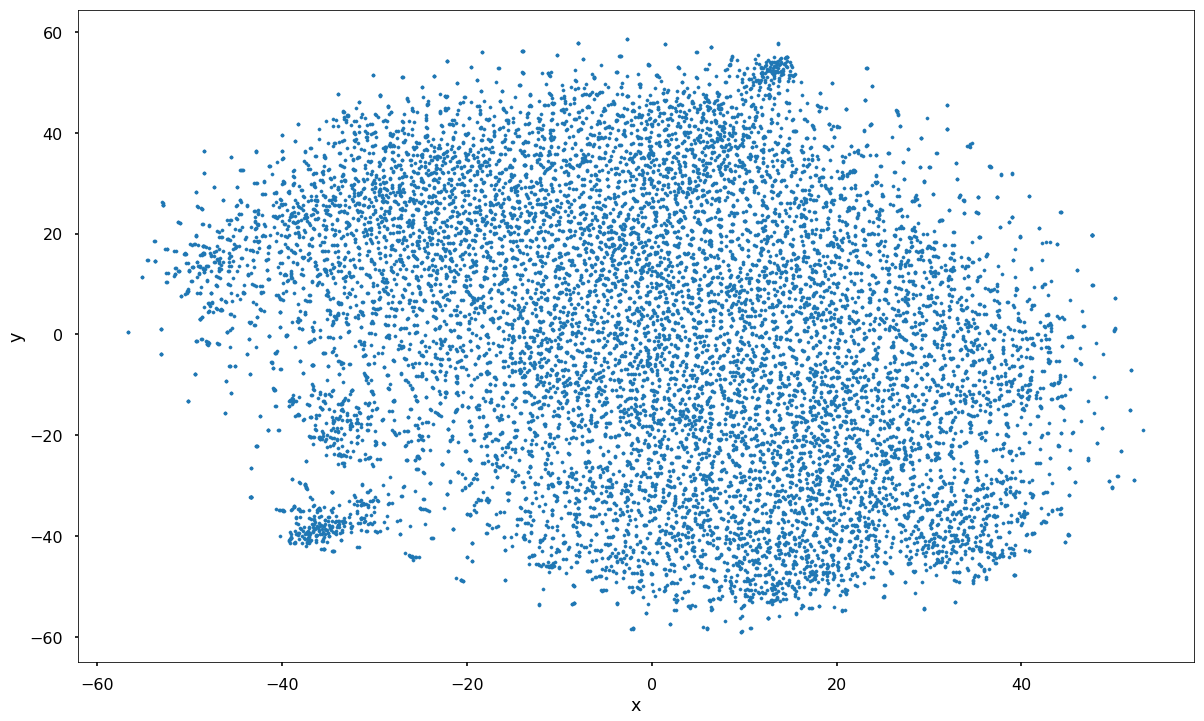

In [17]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))


In [18]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter('x', 'y', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

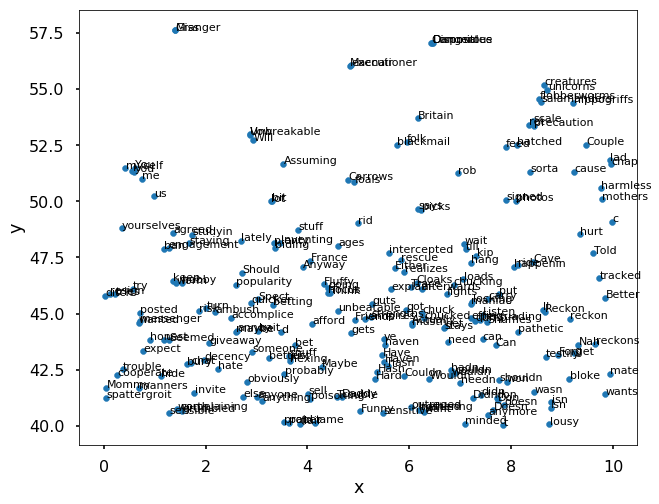

In [19]:
plot_region(x_bounds=[0, 10], y_bounds=[40, 60])


In [20]:
model.wv.similar_by_word('Gryffindor')

[('Tower', 0.7370198965072632),
 ('team', 0.7253292798995972),
 ('Slytherin', 0.7139464020729065),
 ('House', 0.7125036716461182),
 ('Chaser', 0.7029568552970886),
 ('Hufflepuff', 0.7004252672195435),
 ('Ravenclaw', 0.6990324258804321),
 ('points', 0.6988742351531982),
 ('losers', 0.6902299523353577),
 ('championship', 0.6883875131607056)]

In [21]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = model.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [22]:
nearest_similarity_cosmul('Potter', 'good', 'Voldemort')

Potter is related to good, as Lord is related to Voldemort


'Lord'

In [23]:
mat2d = points.get_values()
keys = points.get_values()[:,0]
mat2d[keys=='Gryffindor']

array([['Gryffindor', -35.86279296875, -14.349145889282227]], dtype=object)

In [37]:
# PARAMETERS
# Size of the embedding vector
num_features = 75

# Minimum word count
min_word_count = 3

# Context window size
context_size = 20

# For paralel computing
num_workers = multiprocessing.cpu_count()

seed = 1

# MODEL

model = word2vec.Word2Vec(sentences=words, sg=1, seed=seed, workers=num_workers, size=num_features, min_count=min_word_count,
                          window=context_size, sample=1e-3)

model.train(words, total_examples=model.corpus_count, epochs=model.epochs)

# Characters to query, by house
grif = ['Godric', 'Dumbledore', 'Hagrid', 'McGonagall', 'Arthur', 'Molly', 'James', 'Lily', 'Sirius', 'Pettigrew', 'Lupin', 
        'Charlie', 'Wood', 'Percy', 'Angelina', 'Fred', 'George', 'Jordan', 'McLaggen','Bell', 'Harry', 'Ron', 'Hermione', 
        'Dean', 'Neville', 'Lavender', 'Parvati', 'Seamus', 'Colin', 'Ginny']
slit = ['Horace', 'Voldemort', 'Umbridge', 'Bellatrix', 'Lucius', 'Narcissa', 'Snape', 'Regulus', 'Flint', 'Draco', 'Crabbe', 
        'Goyle', 'Pansy']
huff = ['Sprout', 'Tonks', 'Cedric', 'Zacharias', 'Justin', 'Macmillan', 'Hannah', 'Susan', 'Helga']
rave = ['Cho', 'Luna','Helena', 'Myrtle', 'Flitwick', 'Xenophilius', 'Lockhart', 'Trelawney', 'Quirrell']

# All characters
characters = np.concatenate((grif, slit, huff, rave))

# Real labels
houses_true = np.concatenate((np.repeat(['Gryffindor'], len(grif)), np.repeat(['Slytherin'], len(slit)),
                              np.repeat(['Hufflepuff'], len(huff)), np.repeat(['Ravenclaw'], len(rave))))
# List of houses
houses = np.unique(houses_true)

# Assignation of the characters to its respective house
sim_mat = np.zeros([characters.shape[0], houses.shape[0]])
assignation = np.zeros([characters.shape[0],2],dtype='<U12')
for i, character in enumerate(characters):
    for j,house in enumerate(houses):
        sim_mat[i,j] = model.wv.similarity(character,house)
    assignation[i,0] = character
    assignation[i,1] = houses[np.argmax(sim_mat[i,:])]


In [38]:
print(assignation)

[['Godric' 'Gryffindor']
 ['Dumbledore' 'Slytherin']
 ['Hagrid' 'Hufflepuff']
 ['McGonagall' 'Gryffindor']
 ['Arthur' 'Hufflepuff']
 ['Molly' 'Gryffindor']
 ['James' 'Gryffindor']
 ['Lily' 'Gryffindor']
 ['Sirius' 'Gryffindor']
 ['Pettigrew' 'Gryffindor']
 ['Lupin' 'Hufflepuff']
 ['Charlie' 'Hufflepuff']
 ['Wood' 'Gryffindor']
 ['Percy' 'Gryffindor']
 ['Angelina' 'Gryffindor']
 ['Fred' 'Gryffindor']
 ['George' 'Gryffindor']
 ['Jordan' 'Gryffindor']
 ['McLaggen' 'Hufflepuff']
 ['Bell' 'Gryffindor']
 ['Harry' 'Gryffindor']
 ['Ron' 'Gryffindor']
 ['Hermione' 'Gryffindor']
 ['Dean' 'Hufflepuff']
 ['Neville' 'Gryffindor']
 ['Lavender' 'Gryffindor']
 ['Parvati' 'Ravenclaw']
 ['Seamus' 'Gryffindor']
 ['Colin' 'Hufflepuff']
 ['Ginny' 'Gryffindor']
 ['Horace' 'Hufflepuff']
 ['Voldemort' 'Slytherin']
 ['Umbridge' 'Gryffindor']
 ['Bellatrix' 'Slytherin']
 ['Lucius' 'Slytherin']
 ['Narcissa' 'Slytherin']
 ['Snape' 'Slytherin']
 ['Regulus' 'Gryffindor']
 ['Flint' 'Slytherin']
 ['Draco' 'Slytherin']

In [39]:
equals = assignation[:,1]==houses_true
accuracy = np.sum(equals)/equals.shape[0]

print('Evaluated Characters: ' + str(len(equals)))
format(accuracy, '.4f')
print('Classification accuracy is: ' + str(format(100*accuracy,'.2f')) + '%')

Evaluated Characters: 61
Classification accuracy is: 70.49%


# EXPERIMENT 1

In [54]:
w1 = 'wizard'
w2 = 'man'
w3 = 'woman'
model.wv.similar_by_vector(model.wv[w1]-model.wv[w2]+model.wv[w3])


[('witch', 0.7769855260848999),
 ('wizard', 0.7579313516616821),
 ('woman', 0.7549241185188293),
 ('Muggle', 0.5952701568603516),
 ('sold', 0.5696943998336792),
 ('navy', 0.5496230721473694),
 ('parentage', 0.5488064289093018),
 ('Maintenance', 0.5486140847206116),
 ('teenagers', 0.5347214341163635),
 ('remedies', 0.5328919291496277)]

In [61]:
w1 = 'Ron'
w2 = 'wand'
model.wv.similar_by_vector(model.wv[w1]-model.wv[w2])

[('Ron', 0.39088380336761475),
 ('Sunday', 0.38408735394477844),
 ('Blast', 0.36490246653556824),
 ('arguing', 0.3635554313659668),
 ('Ginny', 0.3620354235172272),
 ('eating', 0.35882264375686646),
 ('embarrassing', 0.3577997386455536),
 ('Ended', 0.3533431589603424),
 ('woken', 0.34288129210472107),
 ('craning', 0.34206604957580566)]

In [112]:
w1 = 'Dobby'
w2 = 'sock'
model.wv.similar_by_vector(model.wv[w1]+model.wv[w2])

[('Dobby', 0.9355895519256592),
 ('sock', 0.8237074613571167),
 ('freed', 0.7866958975791931),
 ('elf', 0.7853637337684631),
 ('sir', 0.7656044960021973),
 ('squeaked', 0.7299880981445312),
 ('plucking', 0.6950065493583679),
 ('nosing', 0.6889352202415466),
 ('Winky', 0.6774316430091858),
 ('shorts', 0.6763931512832642)]

In [106]:
w1 = 'sock'
model.wv.similar_by_vector(model.wv[w1])

[('sock', 1.0000001192092896),
 ('shorts', 0.7591308951377869),
 ('pillowcase', 0.747238039970398),
 ('clawlike', 0.7310197949409485),
 ('sweater', 0.727634847164154),
 ('unwrapped', 0.7253797650337219),
 ('gillyweed', 0.7190746068954468),
 ('parcels', 0.717485785484314),
 ('attach', 0.7153047919273376),
 ('freed', 0.710524320602417)]

# EXPERIMENT 2

In [122]:
iterations = 15
accuracy_vec = np.zeros(iterations)

for iteration in range(iterations):
    # PARAMETERS
    # Size of the embedding vector
    num_features = 50

    # Minimum word count
    min_word_count = 3

    # Context window size
    context_size = 30

    # For paralel computing
    num_workers = multiprocessing.cpu_count()

    seed = 1


    # MODEL2

    model2 = word2vec.Word2Vec(sentences=words, sg=1, seed=seed, workers=num_workers, size=num_features, min_count=min_word_count,
                              window=context_size, sample=1e-3)

    model2.train(words, total_examples=model2.corpus_count, epochs=model.epochs)

    # Characters to query, by house
    grif = ['Godric', 'Dumbledore', 'Hagrid', 'McGonagall', 'Arthur', 'Molly', 'James', 'Lily', 'Sirius', 'Pettigrew', 'Lupin', 
            'Charlie', 'Wood', 'Percy', 'Angelina', 'Fred', 'George', 'Jordan', 'McLaggen','Bell', 'Harry', 'Ron', 'Hermione', 
            'Dean', 'Neville', 'Lavender', 'Parvati', 'Seamus', 'Colin', 'Ginny']
    slit = ['Horace', 'Voldemort', 'Umbridge', 'Bellatrix', 'Lucius', 'Narcissa', 'Snape', 'Regulus', 'Flint', 'Draco', 'Crabbe', 
            'Goyle', 'Pansy']
    huff = ['Sprout', 'Tonks', 'Cedric', 'Zacharias', 'Justin', 'Macmillan', 'Hannah', 'Susan', 'Helga']
    rave = ['Cho', 'Luna','Helena', 'Myrtle', 'Flitwick', 'Xenophilius', 'Lockhart', 'Trelawney', 'Quirrell']

    # All characters
    characters = np.concatenate((grif, slit, huff, rave))

    # Real labels
    houses_true = np.concatenate((np.repeat(['Gryffindor'], len(grif)), np.repeat(['Slytherin'], len(slit)),
                                  np.repeat(['Hufflepuff'], len(huff)), np.repeat(['Ravenclaw'], len(rave))))
    # List of houses
    houses = np.unique(houses_true)

    # Assignation of the characters to its respective house
    sim_mat = np.zeros([characters.shape[0], houses.shape[0]])
    assignation = np.zeros([characters.shape[0],2],dtype='<U12')
    for i, character in enumerate(characters):
        for j,house in enumerate(houses):
            sim_mat[i,j] = model2.wv.similarity(character,house)
        assignation[i,0] = character
        assignation[i,1] = houses[np.argmax(sim_mat[i,:])]


    equals = assignation[:,1]==houses_true
    accuracy = np.sum(equals)/equals.shape[0]

    #     print('Evaluated Characters: ' + str(len(equals)))
    #     format(accuracy, '.4f')
    print('Trial accuracy is: ' + str(format(100*accuracy,'.2f')) + '%')
    accuracy_vec[iteration] = accuracy
    #     print(assignation)


Trial accuracy is: 65.57%
Trial accuracy is: 62.30%
Trial accuracy is: 68.85%
Trial accuracy is: 63.93%
Trial accuracy is: 65.57%


KeyboardInterrupt: 

In [ ]:
print('Total accuracy is: ' + str(format(100*np.mean(accuracy_vec),'.2f')) + '%')

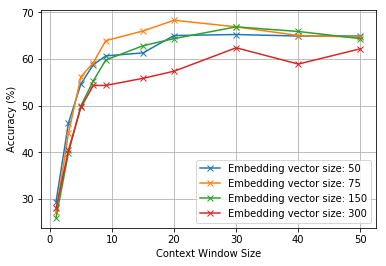

In [144]:
cont_size = [ 1,     3,     5,     7,     9,    15,    20,    30,    40,     50]
feat_50 =  [29.40, 46.23, 54.64, 58.80, 60.66, 61.31, 65.03, 65.25, 64.92, 64.92]
feat_75 =  [27.10, 44.04, 56.17, 59.23, 63.93, 66.01, 68.31, 66.89, 65.03, 64.70]
feat_150 = [25.90, 39.89, 49.95, 55.30, 59.78, 62.84, 64.37, 66.89, 65.90, 64.37]
feat_300 = [27.93, 40.44, 49.62, 54.32, 54.32, 55.85, 57.38, 62.40, 58.91, 62.19]

plt.plot(cont_size, feat_50, '-x', label='Embedding vector size: 50')
plt.plot(cont_size, feat_75, '-x', label='Embedding vector size: 75')
plt.plot(cont_size, feat_150, '-x', label='Embedding vector size: 150')
plt.plot(cont_size, feat_300, '-x', label='Embedding vector size: 300')
plt.xlabel('Context Window Size')
plt.ylabel('Accuracy (%)')
# plt.title('dsadasd')
# plt.ylim(0, 2)
# plt.ylim(1e-13, 1e3)
plt.grid()
plt.legend()

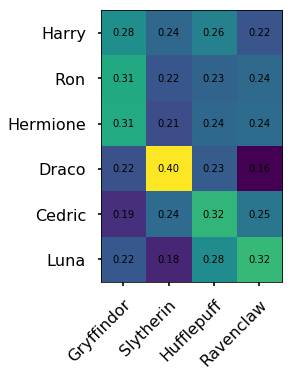

In [151]:
grif = ['Godric', 'Dumbledore', 'Hagrid', 'McGonagall', 'Arthur', 'Molly', 'James', 'Lily', 'Sirius', 'Pettigrew', 'Lupin', 
            'Charlie', 'Wood', 'Percy', 'Angelina', 'Fred', 'George', 'Jordan', 'McLaggen','Bell', 'Harry', 'Ron', 'Hermione', 
            'Dean', 'Neville', 'Lavender', 'Parvati', 'Seamus', 'Colin', 'Ginny']
slit = ['Horace', 'Voldemort', 'Umbridge', 'Bellatrix', 'Lucius', 'Narcissa', 'Snape', 'Regulus', 'Flint', 'Draco', 'Crabbe', 
            'Goyle', 'Pansy']
huff = ['Sprout', 'Tonks', 'Cedric', 'Zacharias', 'Justin', 'Macmillan', 'Hannah', 'Susan', 'Helga']
rave = ['Cho', 'Luna','Helena', 'Myrtle', 'Flitwick', 'Xenophilius', 'Lockhart', 'Trelawney', 'Quirrell']
    
    
characters2 = np.array(['Harry', 'Ron', 'Hermione', 'Draco', 'Cedric', 'Luna'])
houses = np.array(['Gryffindor', 'Slytherin', 'Hufflepuff', 'Ravenclaw'])

sim_mat = np.zeros([characters2.shape[0], houses.shape[0]])
for i, character in enumerate(characters2):
    for j,house in enumerate(houses):
        sim_mat[i,j] = model.wv.similarity(character,house)

        
# Normalize the rows
for i in range(sim_mat.shape[0]):
    sim_mat[i,:] = np.divide(sim_mat[i,:], np.sum(sim_mat[i,:]))        

        
# Show the matrix
fig, ax = plt.subplots()
im = ax.imshow(sim_mat)

# We want to show all ticks...
ax.set_xticks(np.arange(len(houses)))
ax.set_yticks(np.arange(len(characters2)))
# ... and label them with the respective list entries
ax.set_xticklabels(houses)
ax.set_yticklabels(characters2)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(characters2)):
    for j in range(len(houses)):
        text = ax.text(j, i, format(sim_mat[i, j],'.2f'), ha="center", va="center")

# ax.set_title("Harvest of local farmers (in tons/year)")
# fig.tight_layout()
fig.set_size_inches(10,5)

# EXPERIMENT 3

In [142]:
# PARAMETERS
# Size of the embedding vector
num_features = 300

# Minimum word count
min_word_count = 3

# Context window size
context_size = 30

# For paralel computing
num_workers = multiprocessing.cpu_count()

seed = 1


# MODEL2

model3 = word2vec.Word2Vec(sentences=words, sg=1, seed=seed, workers=num_workers, size=num_features, min_count=min_word_count,
                          window=context_size, sample=1e-3)

model3.train(words, total_examples=model3.corpus_count, epochs=model3.epochs)

# Characters to query, by house
grif = ['Godric', 'Dumbledore', 'Hagrid', 'McGonagall', 'Arthur', 'Molly', 'James', 'Lily', 'Sirius', 'Pettigrew', 'Lupin', 
        'Charlie', 'Wood', 'Percy', 'Angelina', 'Fred', 'George', 'Jordan', 'McLaggen','Bell', 'Harry', 'Ron', 'Hermione', 
        'Dean', 'Neville', 'Lavender', 'Parvati', 'Seamus', 'Colin', 'Ginny']
slit = ['Horace', 'Voldemort', 'Umbridge', 'Bellatrix', 'Lucius', 'Narcissa', 'Snape', 'Regulus', 'Flint', 'Draco', 'Crabbe', 
        'Goyle', 'Pansy']
huff = ['Sprout', 'Tonks', 'Cedric', 'Zacharias', 'Justin', 'Macmillan', 'Hannah', 'Susan', 'Helga']
rave = ['Cho', 'Luna','Helena', 'Myrtle', 'Flitwick', 'Xenophilius', 'Lockhart', 'Trelawney', 'Quirrell']

# All characters
characters = np.concatenate((grif, slit, huff, rave))

# Real labels
houses_true = np.concatenate((np.repeat(['Gryffindor'], len(grif)), np.repeat(['Slytherin'], len(slit)),
                              np.repeat(['Hufflepuff'], len(huff)), np.repeat(['Ravenclaw'], len(rave))))
# List of houses
houses = np.unique(houses_true)

# Assignation of the characters to its respective house
sim_mat = np.zeros([characters.shape[0], houses.shape[0]])
assignation = np.zeros([characters.shape[0],2],dtype='<U12')
for i, character in enumerate(characters):
    for j,house in enumerate(houses):
        sim_mat[i,j] = model3.wv.similarity(character,house)
    assignation[i,0] = character
    assignation[i,1] = houses[np.argmax(sim_mat[i,:])]


equals = assignation[:,1]==houses_true
accuracy = np.sum(equals)/equals.shape[0]

#     print('Evaluated Characters: ' + str(len(equals)))
#     format(accuracy, '.4f')




print('Evaluated Characters: ' + str(len(equals)))
format(accuracy, '.4f')
print('Classification accuracy is: ' + str(format(100*accuracy,'.2f')) + '%')

Evaluated Characters: 61
Classification accuracy is: 63.93%


In [145]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Dataset
X = np.zeros((characters.shape[0],model3.wv.vectors.shape[1]))
for i, character in enumerate(characters):
    X[i,:] = model3.wv.get_vector(character)
    
# Labels
Y_raw = houses_true
encoded_Y = LabelEncoder().fit_transform(Y_raw)
Y = np_utils.to_categorical(encoded_Y)

# Model
def baseline_model():
    nnmodel = Sequential()
#     nnmodel.add(Dense(10, input_dim=model3.wv.vectors.shape[1], activation='relu'))
    nnmodel.add(Dense(houses.shape[0], input_dim=model3.wv.vectors.shape[1], activation='softmax'))
    # Compile model
    nnmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nnmodel

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)


# KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

# Results
results = cross_val_score(estimator, X, Y, cv=kfold)

print('Accuracy: ' + str(format(100*results.mean(),'.2f')) + '%')
print('Std: ' + str(format(100*results.std(),'.2f')))

Accuracy: 68.81%
Std: 18.94
